In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._children = set(_children)
        self._op = _op
        self._label = _label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if isinstance(other, Value) == 0: # a + 1
            other = Value(other)
        outcome = Value(self.data + other.data, (self, other), '+', self._label)
        def _backward():
            self.grad += 1.0 * outcome.grad
            other.grad += 1.0 * outcome.grad
        outcome._backward = _backward
        return outcome
    
    def __mul__(self, other):
        if isinstance(other, Value) == 0: # a * (int, float)
            other = Value(other)
        outcome = Value(self.data * other.data, (self, other), '*', self._label)
        def _backward():
            self.grad += other.data * outcome.grad
            other.grad += self.data * outcome.grad
        outcome._backward = _backward
        return outcome
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        outcome = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * outcome.grad
        outcome._backward = _backward
        return outcome
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __rmul__(self, other):
        return self * other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        outcome = Value((math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1), (self, ), 'tanh', self._label)
        def _backward():
            self.grad += (1 - outcome.data**2) * outcome.grad
        outcome._backward = _backward
        return outcome
    
    def exp(self):
        outcome = Value(math.exp(self.data), (self, ), 'exp', self._label)
        def _backward():
            self.grad += outcome.data * outcome.grad
        outcome._backward = _backward
        return outcome
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(curr):
            for child in curr._children:
                if child not in visited:
                    visited.add(child)
                    build_topo(child)
            topo.append(curr)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [3]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
e = a * b
e._label = 'e'
c = Value(10, _label='c')
d = e + c
d._label = 'd'
f = Value(-2, _label='f')
L = d * f
L._label = 'L'

In [4]:
import graphviz 

def trace(root):
    edges, nodes = set(), set()
    def build(curr):
        if curr not in nodes:
            for child in curr._children:
                edges.add((curr, child))
                build(child)
            nodes.add(curr)
    build(root)
    return edges, nodes

# print(trace(d))

def draw_dot(root):
    dot = graphviz.Digraph(node_attr={'shape': 'plaintext'}, graph_attr={'rankdir': 'LR'})
    edges, nodes = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(name = uid, label = '{%s | data %.4f | grad %.4f}' % (node._label, node.data, node.grad), shape='record')
        if node._op != '':
            dot.node(name = uid + node._op, label = node._op, shape='oval')
            dot.edge(uid + node._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n2)), str(id(n1)) + n1._op)
    return dot

In [5]:
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

b = Value(6.8813735870195432, _label='b')

x1w1 = x1 * w1; x1w1._label = 'x1 * w1'
x2w2 = x2 * w2; x2w2._label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'

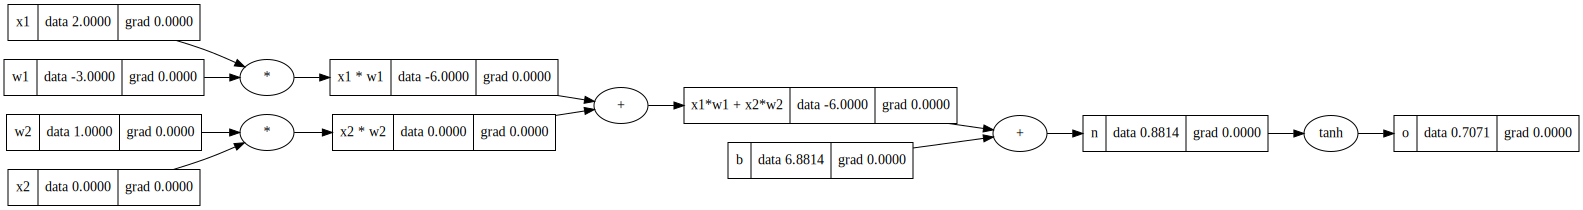

In [6]:
draw_dot(o)

In [7]:
o.backward()

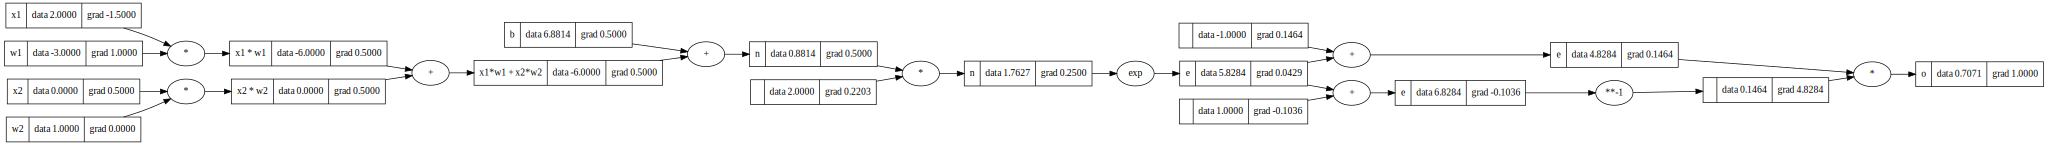

In [8]:
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

b = Value(6.8813735870195432, _label='b')

x1w1 = x1 * w1; x1w1._label = 'x1 * w1'
x2w2 = x2 * w2; x2w2._label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._label = 'n'
#------
e = (2 * n).exp(); e._label = 'e'
o = (e - 1)/(e + 1); o._label = 'o'
#------
o.backward()
draw_dot(o)

In [9]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.item())
o. backward()

print('------')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [10]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        outcome = act.tanh()
        return outcome
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outcome = [n(x) for n in self.neurons]
        return outcome[0] if len(outcome) == 1 else outcome
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [11]:
x = [2.0, 3.0, -5.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.815763893532258)

In [12]:
xs = [[2.0, 3.0, -1.0],
     [3.0, -1.0, 0.5],
     [0.5, 1.0, 1.0], 
     [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [17]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])
    
    #backward pass
    for param in n.parameters():
        param.grad = 0.0
    loss.backward()
    
    # update
    for param in n.parameters():
        param.data += -0.01 * param.grad
        
    print(k, loss.data)

0 0.06180500759322984
1 0.06045467476347114
2 0.05915791006636006
3 0.057911707491622166
4 0.05671327606136824
5 0.05556002131604194
6 0.054449528650215434
7 0.053379548289095316
8 0.05234798172286039
9 0.05135286943860692
10 0.050392379809254165
11 0.04946479901571871
12 0.04856852189338097
13 0.04770204360666197
14 0.0468639520666725
15 0.046052921016628445
16 0.04526770371822633
17 0.044507127179631095
18 0.04377008687225574
19 0.04305554188926916


In [18]:
ypred

[Value(data=0.9355838158236847),
 Value(data=-0.9662424254667314),
 Value(data=-0.8653799238010892),
 Value(data=0.8598430938153155)]